In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.config import *
from scipy.cluster import hierarchy

In [122]:
import scipy.cluster.hierarchy as sch
import radialtree as rt
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm

In [123]:

receptor_families = pd.read_csv('data/targets_and_families_guidetopharmacologyorg.csv', header = 0)
receptor_families = receptor_families.reset_index()
receptor_families.columns = receptor_families.loc[0]
receptor_families = receptor_families.drop(index = 0)
receptor_families = receptor_families.reset_index(drop = True)

In [124]:
coefs = pd.read_csv('data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col = 0)


In [125]:
cluster_base = 'Type'#'Family name'

In [126]:
receptor_type_mapping = (receptor_families[[cluster_base, 'HGNC symbol']].dropna().drop_duplicates('HGNC symbol').set_index('HGNC symbol')).to_dict()[cluster_base]

In [127]:
coef_rec_complexes = coefs.reset_index()['index'].str.split('_', expand =True)
coef_rec_complexes.index = coefs.index

In [128]:
all_rec = coefs.index
a = receptor_families[receptor_families['HGNC symbol'].isin(list(all_rec))]

In [129]:
def mapping_receptor_families(complex, receptors, receptors_not_in_database):
    c0 = complex.dropna()
    types = {}
    for rec in c0:
        if rec in receptors:
            types[rec]= receptor_type_mapping[rec]
        else:
            receptors_not_in_database.append(rec)
            return np.nan
    # if all element are identical return the element (receptor type)
    if len(set(types.values())) == 1:
        return list(set(types.values()))[0]
    else:
        print(complex, 'different types in complex')
        return np.nan

In [130]:
receptors = list(receptor_type_mapping.keys())
receptors_not_in_database = []
coef_rec_complexes['type'] = coef_rec_complexes.apply(lambda x: mapping_receptor_families(x, receptors, receptors_not_in_database), axis = 1)
print(len(receptors_not_in_database))

32


In [131]:
coef_rec_complexes = coef_rec_complexes.dropna(subset = 'type')

In [132]:
lut = dict(zip(set(coef_rec_complexes.type), (sns.color_palette('viridis', len(set(coef_rec_complexes.type))).as_hex())))
colors = coef_rec_complexes.type.map(lut)

In [133]:
len(lut.keys())

7

In [134]:
map_receptors ={
    'gpcr':'GPCR',
    'catalytic_receptor':'CATALYTIC RECEPTOR',
    'enzyme':'ENZYME',
    'other_protein':'OTHER PROTEIN',
    'nhr':'OTHER PROTEIN',
    'lgic':'OTHER PROTEIN',
    'vgic': 'OTHER PROTEIN',
    'transporter':'OTHER PROTEIN'
}
coef_rec_complexes.type = coef_rec_complexes.type.map(map_receptors)

In [135]:
import matplotlib.cm as cm
cmap = cm.get_cmap('RdBu_r')
color = {
    'CATALYTIC RECEPTOR':cmap(0.1),
    'ENZYME':cmap(0.3),
    'GPCR':cmap(0.6),
    'OTHER PROTEIN':cmap(0.9)
    }
colors = coef_rec_complexes.type.map(color)

In [136]:
coef_rec_complexes['color'] = colors

0.15000000000000002
1.1500000000000001
dict_values([(0.1272587466359093, 0.395847750865052, 0.6687427912341408, 1.0), (0.5664744329104192, 0.7687043444828914, 0.8685121107266437, 1.0), (0.9921568627450981, 0.8588235294117647, 0.7803921568627451, 1.0), (0.6922722029988465, 0.0922722029988466, 0.1677047289504037, 1.0)])


Text(0, 0.3, 'Receptors (229)')

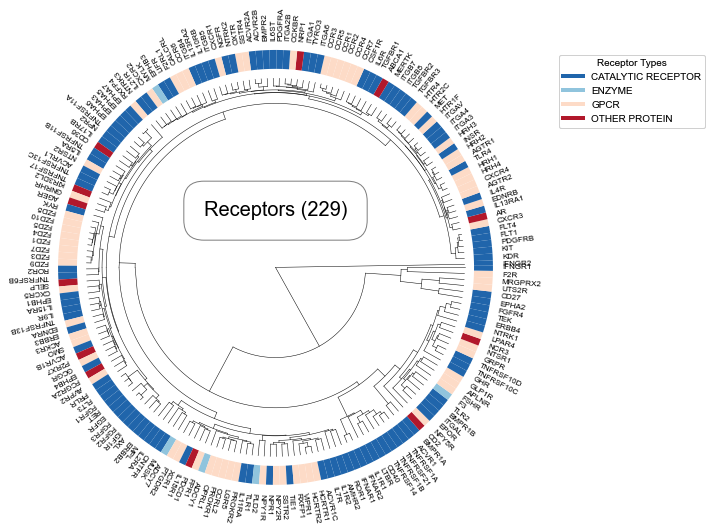

In [142]:
data = coefs.loc[coef_rec_complexes.index]

D = pdist(data, metric='euclidean') 
D_square = squareform(D)
Y = sch.linkage(D_square, method='average')
labels = data.index.tolist()
Z2 = sch.dendrogram(Y, labels=labels, no_plot=True, color_threshold=0)

colors_dict={"Receptor Types":coef_rec_complexes.loc[data.index, 'color']}
colors_legends={"Receptor Types":{"colors":color.values(), 
                                 "labels": color.keys()}}

fig, ax = plt.subplots(figsize=(30, 8))
rt.radialTreee(Z2, colorlabels=colors_dict, colorlabels_legend=colors_legends, ax= ax)
plt.text(x = 0, y = 0.3, s = 'Receptors (229)', fontsize = 20, ha = 'center', va = 'center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1', alpha= 0.5))
# plt.savefig('figures/paper_figures/Fig3A_v2.pdf', transparent = True, bbox_inches = 'tight')
# plt.savefig('figures/paper_figures/Fig3A_v2.png', transparent = True, bbox_inches = 'tight', dpi = 350)
# plt.savefig('figures/paper_figures/Fig3A_v2.jpg', transparent = True, bbox_inches = 'tight', dpi = 350)

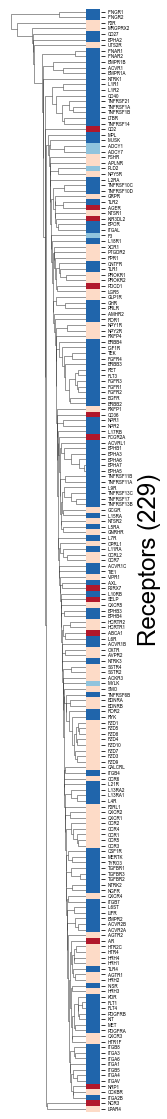

In [140]:
g = sns.clustermap(coefs.loc[coef_rec_complexes.index],row_colors = colors, yticklabels = 1,col_cluster = False,
                   figsize = (2.5, 16), method = 'average', dendrogram_ratio=(0.84, 0), colors_ratio=0.15, mask=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 4.5)
g.cax.remove()
g.ax_row_colors.set_xticks([])
rec_no = len(coefs)
g.ax_heatmap.set_ylabel(f'Receptors ({rec_no})', fontsize = 24)
# plt.savefig('figures/paper_figures/Fig3A.pdf', transparent = True, bbox_inches = 'tight')
# plt.savefig('figures/paper_figures/Fig3A.png', transparent = True, bbox_inches = 'tight', dpi = 350)
# plt.savefig('figures/paper_figures/Fig3A.jpg', transparent = True, bbox_inches = 'tight', dpi = 350)

plt.show()
